In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from src.utils.data_utils import get_related_videos_with_keywords, keyword_searcher
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff

# supress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = "../data"

In [ ]:
# # Note: this dataset is created using script in src/scripts/sport_videos.py

# # Load sports category videos dataset (with descriptions and tags)
# pq_sports = pq.ParquetFile(os.path.join(DATA_PATH, "filtered_sport_category_metadata.parquet"))
# df_vd_sports = pq_sports.read().to_pandas()

# # Change upload_date to datetime
# df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], format="%Y-%m-%d %H:%M:%S")

In [9]:
df_vd_sports = pd.read_parquet(DATA_PATH+"/filtered_sport_category_metadata.parquet",engine="fastparquet")
# Change upload_date to datetime
df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], format="%Y-%m-%d %H:%M:%S")

In [10]:
df_vd_sports.head(5)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:57.427254,Can I catch 100 lbs of catfish LIVE. Me and Ja...,35.0,JOeSxtcNdHQ,8620,1673.0,"catfishing,fishing,fishing challenge,catfish,c...",Catching 100 lbs of Catfish 🔴Live,2019-10-01,48737.0
1,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.108323,,15.0,EPMLTw2zINw,355,1297.0,,big cat,2019-10-01,19999.0
2,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.773085,Are you ready to enter the high fashion world ...,78.0,Y1_pK68iSYQ,603,3305.0,"Catfishing,how to catch catfish,fishing,classy...",Classy Catfishing - How to Catch Catfish the P...,2019-09-28,58518.0
3,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:59.465346,Saltwater fishing out of Newquay Cornwall UK. ...,70.0,jF8TSo3ZfTc,1426,1889.0,"Fishing,Fishing uk,Angling,Sea angling,sea ang...",2 Day Saltwater Fishing Catch & Cook - UK Sea ...,2019-09-21,71998.0
4,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:40:00.188768,My family spent 3 weeks touring England and fi...,73.0,Gp00dNaVouo,990,2699.0,"Fishing,catfish,wels catfish,how to catch catf...",How to Catch Wels Catfish - Fishing for Catfis...,2019-09-14,101924.0


In [6]:
def get_all_tags(df: pd.DataFrame) -> list[str]:
    df['tags'] = df['tags'].str.lower()
    df['tags'] = df['tags'].str.replace("world cup", "world_cup")
    df['tags'] = df['tags'].str.replace("table tennis", "table_tennis")
    df['tags'] = df['tags'].str.replace("ping pong", "table_tennis")
    
    all_tags = []
    for tags in df['tags']:
        tag_list = tags.split(",") # "a, b c, d" -> ["a", "b c", "d"]
        for sentence in tag_list:
            all_tags.extend(sentence.split()) # "b c" -> ["b", "c"]
    
    return all_tags

In [7]:
all_tags_sport = get_all_tags(df_vd_sports)

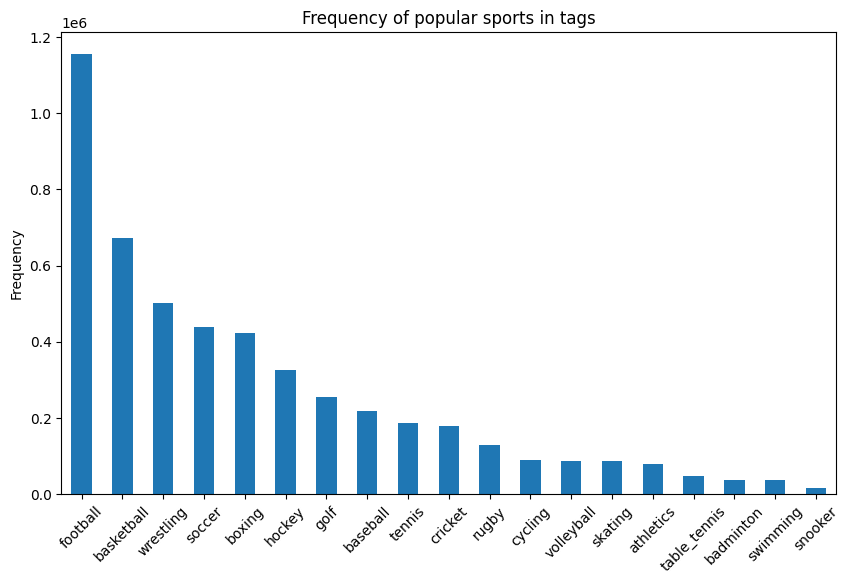

In [8]:
# Frequency of sports in tags
tag_counts = Counter(all_tags_sport)

popular_sports = [
    "soccer", "football", "cricket", "hockey", 
    "tennis", "volleyball", "baseball", "rugby", 
    "golf", "snooker", "basketball", "skating",
    "swimming", "wrestling", "table_tennis", "badminton",
    "cycling", "boxing", "athletics"
]

popular_sports_counts = {sport: tag_counts[sport] for sport in popular_sports}

plt.figure(figsize=(10, 6))
popular_sports_counts_series = pd.Series(popular_sports_counts)
popular_sports_counts_series.sort_values(ascending=False).plot(kind="bar")
plt.title("Frequency of popular sports in tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

---
## Analysis
